# DER Integration and Advanced Applications

| Information | Details |
|----------|---------|
| Lead Author | Hantao Cui |
| Learning Objectives | • Integrate distributed energy resources in T&D co-simulation<br>• Implement solar PV and battery storage models<br>• Analyze reverse power flow scenarios<br>• Explore voltage regulation with high DER penetration<br>• Apply co-simulation to real-world grid challenges |
| Prerequisites | Lessons 3-4 (T&D co-simulation fundamentals and advanced topics) |
| Estimated Time | 120 minutes |
| Topics | DER modeling, solar PV integration, battery storage<br>Reverse power flow, voltage regulation, grid services |

In [2]:
# Environment check and setup
import sys
import importlib
import logging
import time
import numpy as np
import pandas as pd
import matplotlib

%matplotlib inline

import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import helics as h
import opendssdirect as dss
import subprocess
import os
import json
from threading import Thread

import andes

logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] %(message)s')
logger = logging.getLogger(__name__)


print("Checking environment...")
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

# Check for required packages
required_packages = {
    'numpy': 'NumPy',
    'pandas': 'Pandas',
    'matplotlib': 'Matplotlib',
    'helics': 'HELICS',
    'andes': 'ANDES',
    'opendssdirect': 'OpenDSSDirect'
}

missing_packages = []
for package, name in required_packages.items():
    try:
        importlib.import_module(package)
        print(f"✓ {name} is available")
    except ImportError:
        print(f"✗ {name} is NOT available")
        missing_packages.append(package)

if missing_packages:
    print(f"\nPlease install missing packages: {', '.join(missing_packages)}")
    print("Run: mamba install -c conda-forge " + ' '.join(missing_packages))
else:
    print("\n✓ All required packages are available!")

Checking environment...
Python version: 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 17:57:12) 
[GCC 13.3.0]
Python executable: /home/hacui/mambaforge/envs/helics/bin/python3.9
✓ NumPy is available
✓ Pandas is available
✓ Matplotlib is available
✓ HELICS is available
✓ ANDES is available
✓ OpenDSSDirect is available

✓ All required packages are available!


## Introduction

The rapid growth of distributed energy resources fundamentally changes how power systems operate. Solar panels on rooftops, battery storage in garages, and electric vehicles in driveways transform traditionally passive distribution systems into active networks that can both consume and generate power. This transformation creates new challenges that require sophisticated analysis tools.

Traditional power system analysis assumed unidirectional power flow from large generators through transmission lines to distribution loads. DERs break this paradigm. A distribution feeder with high solar penetration might export power to the transmission system during sunny afternoons, then import power when clouds pass over or evening demand peaks. Understanding these bidirectional interactions requires co-simulation that captures both transmission system dynamics and distribution system details.

This lesson extends our T&D co-simulation framework to include DER models, exploring both technical challenges and grid service opportunities that emerge from the distributed energy transformation.

## DER Modeling Fundamentals

### Types of DERs and Their Characteristics

Distributed energy resources encompass various technologies, each with unique operational characteristics that affect grid integration. Solar photovoltaic systems produce power that varies with irradiance and temperature. Battery storage systems can absorb or inject power based on control signals. Combined heat and power units provide both electricity and thermal energy. Electric vehicles present mobile loads that can potentially provide grid services.

For co-simulation, we must capture the essential behaviors of these resources while maintaining computational tractability. This means choosing appropriate model fidelity for our analysis objectives.

Distributed Energy Resource Characteristics
        Resource Power_Range_kW Response_Time  Variability Grid_Services
        Solar PV         1-1000       Seconds         High        Energy
 Battery Storage         5-5000  Milliseconds Controllable      Multiple
    Wind Turbine       100-3000       Seconds         High        Energy
Electric Vehicle          3-150       Seconds    Scheduled V2G potential
       Fuel Cell          1-500       Minutes          Low        Energy


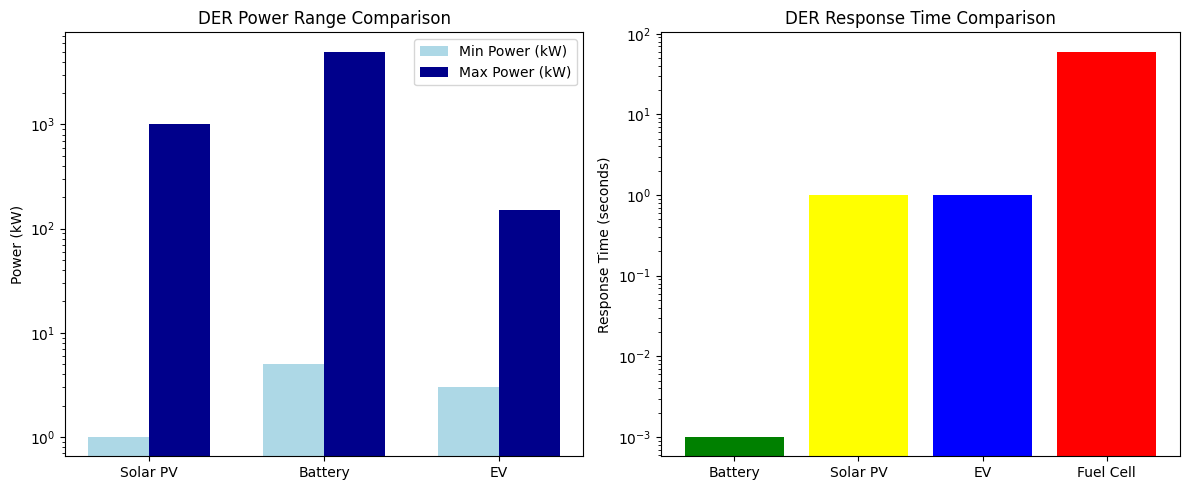

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import helics as h
import opendssdirect as dss

%matplotlib inline


# DER characteristics comparison
der_types = pd.DataFrame({
    'Resource': ['Solar PV', 'Battery Storage', 'Wind Turbine', 'Electric Vehicle', 'Fuel Cell'],
    'Power_Range_kW': ['1-1000', '5-5000', '100-3000', '3-150', '1-500'],
    'Response_Time': ['Seconds', 'Milliseconds', 'Seconds', 'Seconds', 'Minutes'],
    'Variability': ['High', 'Controllable', 'High', 'Scheduled', 'Low'],
    'Grid_Services': ['Energy', 'Multiple', 'Energy', 'V2G potential', 'Energy']
})

print("Distributed Energy Resource Characteristics")
print("=" * 60)
print(der_types.to_string(index=False))

# Visualize DER power capabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Power range comparison
resources = ['Solar PV', 'Battery', 'EV']
min_power = [1, 5, 3]
max_power = [1000, 5000, 150]

x = np.arange(len(resources))
width = 0.35

ax1.bar(x - width/2, min_power, width, label='Min Power (kW)', color='lightblue')
ax1.bar(x + width/2, max_power, width, label='Max Power (kW)', color='darkblue')
ax1.set_ylabel('Power (kW)')
ax1.set_title('DER Power Range Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(resources)
ax1.legend()
ax1.set_yscale('log')

# Response time comparison
response_times = {'Battery': 0.001, 'Solar PV': 1, 'EV': 1, 'Fuel Cell': 60}
ax2.bar(response_times.keys(), response_times.values(), color=['green', 'yellow', 'blue', 'red'])
ax2.set_ylabel('Response Time (seconds)')
ax2.set_title('DER Response Time Comparison')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

### Solar PV Modeling

Solar photovoltaic systems convert sunlight into electricity through semiconductor devices. For grid integration studies, we need models that capture the relationship between environmental conditions and power output while being computationally efficient for co-simulation.

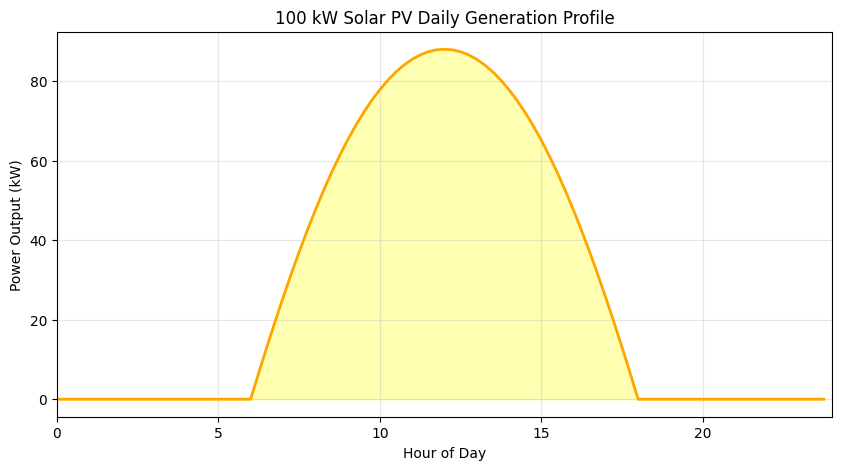

Daily energy generation: 173.7 kWh
Capacity factor: 29.0%


In [4]:
class SimpleSolarPV:
    """
    Simplified solar PV model for co-simulation studies.
    Captures essential behaviors without excessive detail.
    """

    def __init__(self, rated_kw, temp_coeff=-0.004):
        """
        Initialize solar PV model.

        Parameters:
        rated_kw: AC nameplate capacity in kW (at STC: 1000 W/m², 25°C)
        temp_coeff: Temperature coefficient (%/°C, typically -0.4%/°C)
        """
        self.rated_kw = rated_kw
        self.temp_coeff = temp_coeff

    def calculate_power(self, irradiance, temperature, time_of_day=None):
        """
        Calculate PV power output based on conditions.

        Parameters:
        irradiance: Solar irradiance (W/m²)
        temperature: Ambient temperature (°C)
        time_of_day: Hour (0-24) for simple shading effects (not used in basic model)

        Returns:
        power_kw: AC power output in kW
        """
        # Power output as fraction of rated power based on irradiance
        # At 1000 W/m² (STC), output = rated_kw
        power_ratio = irradiance / 1000.0
        power_ac = self.rated_kw * power_ratio

        # Temperature derating
        # Simple cell temperature model: cell temp = ambient + 25°C at full sun
        cell_temp_rise = 25 * power_ratio  # Proportional to irradiance
        cell_temp = temperature + cell_temp_rise
        temp_factor = 1 + self.temp_coeff * (cell_temp - 25)
        power_ac *= temp_factor

        # Ensure non-negative and within rated power
        power_ac = max(0, min(power_ac, self.rated_kw))

        return power_ac

    def create_daily_profile(self, peak_irradiance=1000):
        """
        Generate a typical daily generation profile.
        """
        hours = np.arange(0, 24, 0.25)

        # Simple irradiance model (clear day)
        irradiance = np.zeros_like(hours)
        daylight = (hours >= 6) & (hours <= 18)
        irradiance[daylight] = peak_irradiance * np.sin(np.pi * (hours[daylight] - 6) / 12)

        # Temperature varies during day
        temperature = 20 + 10 * np.sin(np.pi * (hours - 6) / 12)

        # Calculate power for each time
        power = [self.calculate_power(irr, temp) for irr, temp in zip(irradiance, temperature)]

        return hours, np.array(power)


# Demonstrate solar PV model
pv_100kw = SimpleSolarPV(rated_kw=100)
hours, power = pv_100kw.create_daily_profile()

plt.figure(figsize=(10, 5))
plt.plot(hours, power, 'orange', linewidth=2)
plt.fill_between(hours, 0, power, alpha=0.3, color='yellow')
plt.xlabel('Hour of Day')
plt.ylabel('Power Output (kW)')
plt.title('100 kW Solar PV Daily Generation Profile')
plt.grid(True, alpha=0.3)
plt.xlim(0, 24)
plt.show()

print(f"Daily energy generation: {np.trapezoid(power, hours/4):.1f} kWh")
print(f"Capacity factor: {np.mean(power)/100:.1%}")

### Battery Storage Modeling

Battery energy storage systems provide flexibility to the grid by storing excess energy and releasing it when needed. Unlike solar PV, batteries are controllable resources that can provide multiple grid services.

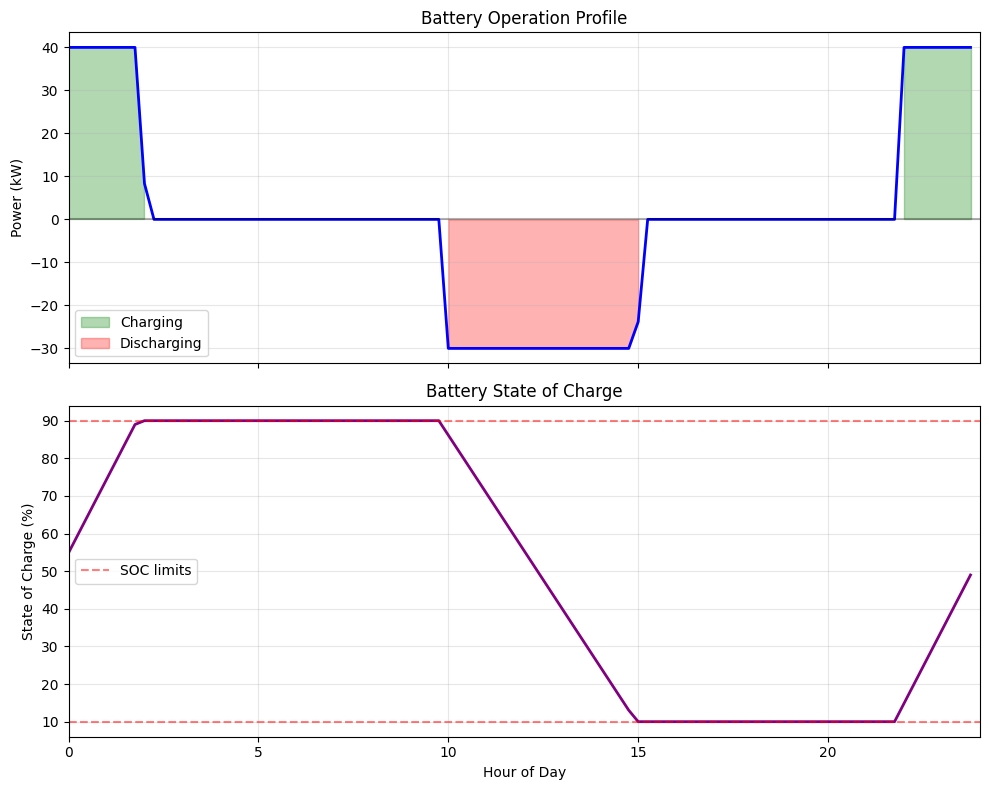

In [5]:
class SimpleBattery:
    """
    Simplified battery storage model for grid integration studies.
    """
    
    def __init__(self, power_kw, energy_kwh, efficiency=0.95, 
                 soc_min=0.1, soc_max=0.9):
        """
        Initialize battery model.
        
        Parameters:
        power_kw: Maximum charge/discharge power (kW)
        energy_kwh: Energy capacity (kWh)
        efficiency: Round-trip efficiency
        soc_min/max: State of charge limits
        """
        self.power_kw = power_kw
        self.energy_kwh = energy_kwh
        self.efficiency = efficiency
        self.soc_min = soc_min
        self.soc_max = soc_max
        self.soc = 0.5  # Initial SOC at 50%
    
    def charge_discharge(self, power_command, duration_hours):
        """
        Execute charge (positive) or discharge (negative) command.
        
        Returns:
        actual_power: Power delivered (limited by constraints)
        new_soc: State of charge after operation
        """
        # Limit power by rating
        power_limited = np.clip(power_command, -self.power_kw, self.power_kw)
        
        # Calculate energy change
        if power_limited > 0:  # Charging
            energy_change = power_limited * duration_hours * np.sqrt(self.efficiency)
        else:  # Discharging
            energy_change = power_limited * duration_hours / np.sqrt(self.efficiency)
            
        # Calculate new SOC
        soc_change = energy_change / self.energy_kwh
        new_soc = self.soc + soc_change
        
        # Apply SOC limits
        if new_soc > self.soc_max:
            new_soc = self.soc_max
            actual_energy = (new_soc - self.soc) * self.energy_kwh
            if power_limited > 0:
                actual_power = actual_energy / (duration_hours * np.sqrt(self.efficiency))
            else:
                actual_power = actual_energy * np.sqrt(self.efficiency) / duration_hours
        elif new_soc < self.soc_min:
            new_soc = self.soc_min
            actual_energy = (new_soc - self.soc) * self.energy_kwh
            if power_limited > 0:
                actual_power = actual_energy / (duration_hours * np.sqrt(self.efficiency))
            else:
                actual_power = actual_energy * np.sqrt(self.efficiency) / duration_hours
        else:
            actual_power = power_limited
            
        # Update SOC
        self.soc = new_soc
        
        return actual_power, self.soc
    
    def get_available_power(self):
        """
        Calculate available charge and discharge power based on SOC.
        """
        # Available energy for discharge
        energy_available_discharge = (self.soc - self.soc_min) * self.energy_kwh
        power_available_discharge = min(self.power_kw,
                                       energy_available_discharge * np.sqrt(self.efficiency))
        
        # Available energy for charge
        energy_available_charge = (self.soc_max - self.soc) * self.energy_kwh
        power_available_charge = min(self.power_kw,
                                    energy_available_charge / np.sqrt(self.efficiency))
        
        return power_available_charge, power_available_discharge

# Demonstrate battery operation
battery = SimpleBattery(power_kw=50, energy_kwh=200)

# Simulate daily operation
hours = np.arange(0, 24, 0.25)
power_commands = []
soc_values = []

for hour in hours:
    # Simple arbitrage strategy: charge at night, discharge during day
    if 0 <= hour < 6 or 22 <= hour < 24:
        command = 40  # Charge at night
    elif 10 <= hour < 20:
        command = -30  # Discharge during day
    else:
        command = 0  # Idle
    
    actual_power, soc = battery.charge_discharge(command, 0.25)
    power_commands.append(actual_power)
    soc_values.append(soc)

# Visualize battery operation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Power profile
ax1.plot(hours, power_commands, 'b-', linewidth=2)
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.fill_between(hours, 0, power_commands, where=np.array(power_commands)>0,
                  alpha=0.3, color='green', label='Charging')
ax1.fill_between(hours, 0, power_commands, where=np.array(power_commands)<0,
                  alpha=0.3, color='red', label='Discharging')
ax1.set_ylabel('Power (kW)')
ax1.set_title('Battery Operation Profile')
ax1.legend()
ax1.grid(True, alpha=0.3)

# SOC profile
ax2.plot(hours, np.array(soc_values)*100, 'purple', linewidth=2)
ax2.axhline(y=battery.soc_min*100, color='r', linestyle='--', alpha=0.5, label='SOC limits')
ax2.axhline(y=battery.soc_max*100, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('State of Charge (%)')
ax2.set_title('Battery State of Charge')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 24)

plt.tight_layout()
plt.show()

## Integrating DERs in T&D Co-simulation

Now we integrate DER models into our transmission-distribution co-simulation framework. The key challenge is properly representing DER impacts on both local distribution voltages and system-wide power flows.

Creating DER-enabled distribution system...


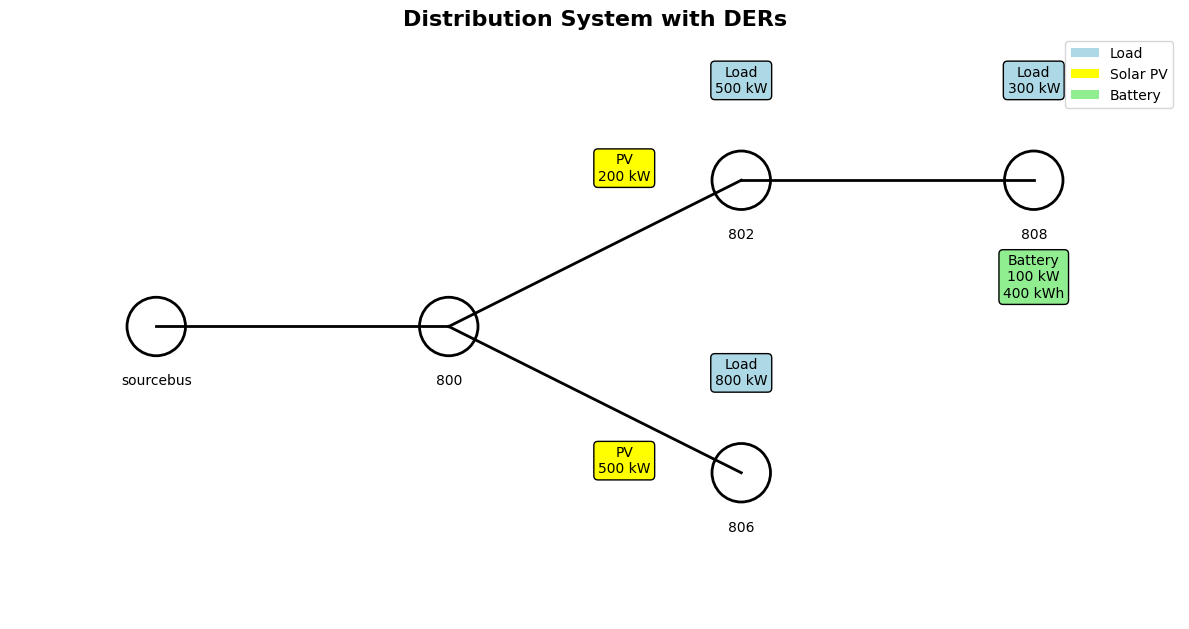


Initial System Conditions:
Total Load: 403.4 kW
Total Generation: 700.0 kW (PV1: 200 kW, PV2: 500 kW)
Net Import: -296.6 kW


In [9]:
def create_der_enabled_distribution_system():
    """
    Create a distribution system with integrated DERs.
    Based on IEEE 34-bus but with added solar and storage.
    """
    # Clear any existing circuit
    dss.Command('Clear')
    
    # Create base distribution system
    commands = [
        "New Circuit.DER_Test basekv=24.9 phases=3",
        
        # Simplified feeder
        "New Line.L1 bus1=sourcebus bus2=800 length=2 units=km",
        "New Line.L2 bus1=800 bus2=802 length=1 units=km",
        "New Line.L3 bus1=800 bus2=806 length=1.5 units=km",
        "New Line.L4 bus1=802 bus2=808 length=0.5 units=km",
        
        # Traditional loads
        "New Load.L1 bus1=802 kV=24.9 kW=500 kvar=100 model=1",
        "New Load.L2 bus1=806 kV=24.9 kW=800 kvar=200 model=1",
        "New Load.L3 bus1=808 kV=24.9 kW=300 kvar=80 model=1",
        
        # Solar PV systems
        "New Generator.PV1 bus1=802 kV=24.9 kW=600 pf=1.0 model=7",  # 600 kW at bus 802
        "New Generator.PV2 bus1=806 kV=24.9 kW=600 pf=1.0 model=7",  # 600 kW at bus 806
        
        # Battery storage
        "New Storage.Battery1 bus1=808 kWrated=100 kWhrated=400 %stored=50",
        
        # Voltage regulation
        "Set Voltagebases=[24.9]",
        "Calcvoltagebases"
    ]
    
    for cmd in commands:
        dss.Command(cmd)
    
    # Set control mode
    dss.Command("Set Mode=Snap")
    dss.Command("Set ControlMode=Static")
    
    return commands


def visualize_der_distribution():
    """
    Create a visual representation of the DER-enabled distribution system.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Bus locations
    buses = {
        'sourcebus': (0, 0),
        '800': (2, 0),
        '802': (4, 1),
        '806': (4, -1),
        '808': (6, 1)
    }
    
    # Draw buses
    for bus, (x, y) in buses.items():
        circle = plt.Circle((x, y), 0.2, color='black', fill=False, linewidth=2)
        ax.add_patch(circle)
        ax.text(x, y-0.4, bus, ha='center', fontsize=10)
    
    # Draw lines
    lines = [
        ('sourcebus', '800'),
        ('800', '802'),
        ('800', '806'),
        ('802', '808')
    ]
    
    for bus1, bus2 in lines:
        x1, y1 = buses[bus1]
        x2, y2 = buses[bus2]
        ax.plot([x1, x2], [y1, y2], 'k-', linewidth=2)
    
    # Draw loads
    loads = {'802': 500, '806': 800, '808': 300}
    for bus, kw in loads.items():
        x, y = buses[bus]
        ax.text(x, y+0.6, f'Load\n{kw} kW', ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue'))
    
    # Draw PV systems
    pvs = {'802': 200, '806': 500}
    for bus, kw in pvs.items():
        x, y = buses[bus]
        ax.text(x-0.8, y, f'PV\n{kw} kW', ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow'))
    
    # Draw battery
    x, y = buses['808']
    ax.text(x, y-0.8, 'Battery\n100 kW\n400 kWh', ha='center', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen'))
    
    # Add legend elements
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightblue', label='Load'),
        Patch(facecolor='yellow', label='Solar PV'),
        Patch(facecolor='lightgreen', label='Battery')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    ax.set_xlim(-1, 7)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Distribution System with DERs', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Create and visualize the system
print("Creating DER-enabled distribution system...")
create_der_enabled_distribution_system()
visualize_der_distribution()

# Solve and show initial conditions
dss.Command("Solve")
print("\nInitial System Conditions:")
print(f"Total Load: {-dss.Circuit.TotalPower()[0]:.1f} kW")
print(f"Total Generation: 700.0 kW (PV1: 200 kW, PV2: 500 kW)")
print(f"Net Import: {-dss.Circuit.TotalPower()[0] - 700:.1f} kW")

## DER-Enhanced Co-simulation Implementation

We now implement a co-simulation that demonstrates how DERs affect both distribution system operation and transmission-distribution interactions. This includes modeling time-varying solar generation and battery dispatch strategies.

In [10]:
class TransmissionFederateANDES:
    """ANDES-based transmission system federate for DER co-simulation"""
    
    def __init__(self, name="TransmissionFederate_DER", interface_bus=4):
        """
        Initialize transmission federate with ANDES.
        
        Parameters:
        -----------
        name : str
            Federate name for HELICS
        interface_bus : int
            Bus number (1-indexed) where distribution system connects
            Valid options for IEEE 14-bus: 4, 6, 7, 9, 10, 11, 12, 13, 14
        """
        self.name = name
        self.fed = None
        self.pub_voltage = None
        self.sub_power = None
        self.sub_solar = None
        
        # ANDES system
        self.system = None
        self.interface_bus = interface_bus
        self.interface_load_idx = None
        self.original_load = {'p': 0.0, 'q': 0.0}
        self.expected_load = {'p': 1.6 * 30.0, 'q': 0.32 * 30.0}

        
        # Results storage
        self.results = {
            'time': [],
            'voltage': [],
            'angle': [],
            'dist_power': [],
            'solar_gen': []
        }
        
    def initialize(self):
        """Initialize the HELICS federate and ANDES system"""
        try:
            # Initialize ANDES system first
            self._initialize_andes()
            
            # Create federate info
            fedinfo = h.helicsCreateFederateInfo()
            h.helicsFederateInfoSetCoreName(fedinfo, self.name)
            h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
            h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
            h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, 0.25)
            
            # Create federate
            self.fed = h.helicsCreateValueFederate(self.name, fedinfo)
            
            # Register publications
            self.pub_voltage = h.helicsFederateRegisterGlobalPublication(
                self.fed, "Trans/voltage", h.helics_data_type_double, "pu"
            )
            
            # Register subscriptions
            self.sub_power = h.helicsFederateRegisterSubscription(
                self.fed, "DER_Dist/total_power", ""
            )
            self.sub_solar = h.helicsFederateRegisterSubscription(
                self.fed, "DER_Dist/solar_generation", "kW"
            )
            
            # Enter execution mode
            h.helicsFederateEnterExecutingMode(self.fed)
            logger.info(f"[{self.name}] Initialized and entered execution mode")
            
        except Exception as e:
            logger.error(f"[{self.name}] Initialization error: {e}")
            raise
    
    def _initialize_andes(self):
        """Initialize ANDES with IEEE 14-bus system"""
        logger.info(f"[{self.name}] Loading IEEE 14-bus system...")
        
        # Configure ANDES logging
        andes.config_logger(stream_level=30)  # Reduce verbosity
        
        # Try to load IEEE 14-bus system
        ieee14_raw = andes.get_case("ieee14/ieee14.raw")
        ieee14_dyr = andes.get_case("ieee14/ieee14.dyr")
        self.system = andes.load(ieee14_raw, addfile=ieee14_dyr, setup=False)
        
        # Configure load models for constant power
        self.system.PQ.config.p2p = 1.0  # 100% constant power for P
        self.system.PQ.config.q2q = 1.0  # 100% constant power for Q
        self.system.PQ.config.p2z = 0.0  # 0% constant impedance
        self.system.PQ.config.q2z = 0.0  # 0% constant impedance

        self.system.TDS.config.no_tqdm = True
        
        # Setup system
        self.system.setup()
        self.system.Toggle.u.v[:] = 0

        # Find load at interface bus
        self._find_interface_load()

        for i, idx in enumerate(self.system.PQ.idx.v):
            if idx == self.interface_load_idx:
                self.system.PQ.p0.v[i] = self.expected_load['p'] / self.system.config.mva
                self.system.PQ.q0.v[i] = self.expected_load['q'] / self.system.config.mva
                logger.info(f"[{self.name}] Set initial load: P={self.expected_load['p']:.1f} MW, Q={self.expected_load['q']:.1f} MVAr")

                break
                
        # Run initial power flow
        logger.info(f"[{self.name}] Running initial power flow...")
        self.system.PFlow.run()
        
        # Initialize TDS
        self.system.TDS.init()
        
        logger.info(f"[{self.name}] ANDES initialization complete")
        
    def _find_interface_load(self):
        """Find the load connected to the interface bus"""
        # ANDES uses 0-based indexing internally
        interface_bus_idx = self.interface_bus - 1
        
        # Find PQ load connected to interface bus
        for i, bus_idx in enumerate(self.system.PQ.bus.v):
            if bus_idx == interface_bus_idx:
                self.interface_load_idx = self.system.PQ.idx.v[i]
                # Store original load values
                self.original_load['p'] = self.system.PQ.p0.v[i] * self.system.config.mva  # MW
                self.original_load['q'] = self.system.PQ.q0.v[i] * self.system.config.mva  # MVAr
                logger.info(f"[{self.name}] Found load at Bus {self.interface_bus}: "
                           f"P={self.original_load['p']:.1f} MW, "
                           f"Q={self.original_load['q']:.1f} MVAr")
                return
        
        # If no load found, create one
        logger.warning(f"[{self.name}] No load found at Bus {self.interface_bus}, creating one")
        self.system.PQ.add(idx='DIST_LOAD', bus=interface_bus_idx, 
                          p=0.0, q=0.0, owner=1)
        self.interface_load_idx = 'DIST_LOAD'
        
    def update_load(self, p_mw, q_mvar):
        """
        Update the load at interface bus using ANDES TDS load modification.
        
        Parameters:
        -----------
        p_mw : float
            Active power in MW
        q_mvar : float
            Reactive power in MVAr
        """
        # Convert to per-unit
        p_pu = p_mw / self.system.config.mva
        q_pu = q_mvar / self.system.config.mva
        
        # Update load using alter method for TDS
        self.system.PQ.alter(src='Ppf', idx=self.interface_load_idx, value=p_pu)
        self.system.PQ.alter(src='Qpf', idx=self.interface_load_idx, value=q_pu)
        
    def get_interface_voltage(self):
        """Get voltage magnitude and angle at interface bus"""
        bus_idx = self.interface_bus - 1
        v_mag = self.system.Bus.v.v[bus_idx]
        v_angle = self.system.Bus.a.v[bus_idx]  # radians
        return v_mag, v_angle
    
    def run_simulation(self, stop_time=24.0, dt=0.25):
        """Run the transmission federate simulation"""
        current_time = 0.0
        
        try:
            while current_time < stop_time:
                # Request time advancement
                requested_time = h.helicsFederateRequestTime(self.fed, current_time + dt)
                
                # Get distribution power
                p_mw = self.original_load['p']  # Default to original load
                q_mvar = self.original_load['q']
                
                if h.helicsInputIsUpdated(self.sub_power):
                    complex_power = h.helicsInputGetComplex(self.sub_power)
                    p_mw = complex_power.real / 1000  # Convert kW to MW
                    q_mvar = complex_power.imag / 1000  # Convert kvar to MVAr
                
                # Get solar generation (for logging)
                solar_gen = 0
                if h.helicsInputIsUpdated(self.sub_solar):
                    solar_gen = h.helicsInputGetDouble(self.sub_solar)
                
                # Update load in ANDES
                self.update_load(p_mw, q_mvar)
                
                # Run TDS to current time
                self.system.TDS.config.tf = requested_time
                self.system.TDS.run()
                
                # Get voltage at interface bus
                v_mag, v_angle = self.get_interface_voltage()
                
                # Publish voltage magnitude
                h.helicsPublicationPublishDouble(self.pub_voltage, v_mag)
                
                # Store results
                self.results['time'].append(requested_time)
                self.results['voltage'].append(v_mag)
                self.results['angle'].append(np.degrees(v_angle))
                self.results['dist_power'].append(p_mw)
                self.results['solar_gen'].append(solar_gen)
                
                logger.info(f"[{self.name}] t={requested_time:.1f}h: V={v_mag:.3f}pu, "
                           f"θ={np.degrees(v_angle):.1f}°, P_dist={p_mw:.1f}MW, "
                           f"Solar={solar_gen:.0f}kW")
                
                current_time = requested_time
                
        except Exception as e:
            logger.error(f"[{self.name}] Simulation error: {e}")
            raise
        finally:
            self.finalize()
    
    def finalize(self):
        """Clean up the federate"""
        if self.fed:
            h.helicsFederateDestroy(self.fed)
            logger.info(f"[{self.name}] Finalized")

In [11]:
class DistributionFederateDER:
    """Distribution system federate with DER integration"""
    
    def __init__(self, name="DER_DistributionFederate", scale_factor=30):
        self.name = name
        self.scale_factor = scale_factor
        self.fed = None
        self.pub_power = None
        self.pub_solar = None
        self.pub_battery = None
        self.sub_voltage = None
        
        # DER models
        self.pv1 = SimpleSolarPV(rated_kw=600)
        self.pv2 = SimpleSolarPV(rated_kw=600)
        self.battery = SimpleBattery(power_kw=400, energy_kwh=1200)
        
        # Results storage
        self.results = {
            'time': [],
            'net_power': [],
            'solar_total': [],
            'battery_power': [],
            'battery_soc': [],
            'voltage': []
        }
        
    def initialize(self):
        """Initialize the HELICS federate and OpenDSS"""
        try:
            # Create federate info
            fedinfo = h.helicsCreateFederateInfo()
            h.helicsFederateInfoSetCoreName(fedinfo, self.name)
            h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
            h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
            h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, 0.25)
            
            # Create federate
            self.fed = h.helicsCreateValueFederate(self.name, fedinfo)
            
            # Register publications
            self.pub_power = h.helicsFederateRegisterGlobalPublication(
                self.fed, "DER_Dist/total_power", h.helics_data_type_complex, ""
            )
            self.pub_solar = h.helicsFederateRegisterGlobalPublication(
                self.fed, "DER_Dist/solar_generation", h.helics_data_type_double, "kW"
            )
            self.pub_battery = h.helicsFederateRegisterGlobalPublication(
                self.fed, "DER_Dist/battery_power", h.helics_data_type_double, "kW"
            )
            
            # Register subscriptions
            self.sub_voltage = h.helicsFederateRegisterSubscription(
                self.fed, "Trans/voltage", ""
            )
            
            # Initialize OpenDSS
            create_der_enabled_distribution_system()
            
            # Enter execution mode
            h.helicsFederateEnterExecutingMode(self.fed)
            logger.info(f"[{self.name}] Initialized and entered execution mode")
            
        except Exception as e:
            logger.error(f"[{self.name}] Initialization error: {e}")
            raise
    
    def calculate_solar_generation(self, hour_of_day):
        """Calculate solar generation based on time of day"""
        if 6 <= hour_of_day <= 18:
            irradiance = 1000 * np.sin(np.pi * (hour_of_day - 6) / 12)
            # Add cloud variations
            if 10 <= hour_of_day <= 14:
                irradiance *= 0.7 + 0.3 * np.random.random()
        else:
            irradiance = 0
            
        temperature = 20 + 10 * np.sin(np.pi * (hour_of_day - 6) / 12)
        
        pv1_power = self.pv1.calculate_power(irradiance, temperature)
        pv2_power = self.pv2.calculate_power(irradiance, temperature)
        
        return pv1_power, pv2_power, pv1_power + pv2_power
    
    def determine_battery_dispatch(self, hour_of_day, total_solar, trans_voltage):
        """Determine battery dispatch strategy"""
        net_load_before_battery = 1600 - total_solar
    
        if total_solar > 600 and self.battery.soc < 0.8:
            # Charge during excess solar (when solar > 40% of load)
            battery_command = min(100, total_solar - 600)
        elif 17 <= hour_of_day <= 21 and self.battery.soc > 0.2:
            # Discharge during evening peak
            battery_command = -150
        elif trans_voltage < 0.98 and self.battery.soc > 0.3:
            # Support grid during low voltage
            battery_command = -100
        elif total_solar < 200 and hour_of_day in [7, 8, 19, 20] and self.battery.soc > 0.4:
            # Morning/evening peak shaving
            battery_command = -80
        else:
            battery_command = 0
    
        return battery_command
    
    def update_opendss_ders(self, pv1_power, pv2_power, battery_power, trans_voltage):
        """Update DER setpoints in OpenDSS"""
        # Update PV generators using Command (more reliable)
        dss.Command(f'Generator.PV1.kW={pv1_power:.2f}')
        dss.Command(f'Generator.PV2.kW={pv2_power:.2f}')
        
        # Update battery using Command (correct way for storage)
        dss.Command(f'Storage.Battery1.kW={-battery_power:.2f}')  # OpenDSS convention: negative=discharge
        
        # Apply transmission voltage using Command
        dss.Command(f'Vsource.source.pu={trans_voltage:.4f}')
        
        # Solve power flow
        dss.Command("Solve")
    
    def run_simulation(self, stop_time=24.0, dt=0.25):
        """Run the distribution federate simulation"""
        current_time = 0.0
        np.random.seed(42)  # For reproducibility
        
        try:
            while current_time < stop_time:
                # Request time advancement
                requested_time = h.helicsFederateRequestTime(self.fed, current_time + dt)
                hour_of_day = requested_time % 24
                
                # Calculate solar generation
                pv1_power, pv2_power, total_solar = self.calculate_solar_generation(hour_of_day)
                
                # Get transmission voltage
                trans_voltage = 1.0
                if h.helicsInputIsUpdated(self.sub_voltage):
                    trans_voltage = h.helicsInputGetDouble(self.sub_voltage)
                
                # Determine battery dispatch
                battery_command = self.determine_battery_dispatch(
                    hour_of_day, total_solar, trans_voltage
                )
                battery_power, battery_soc = self.battery.charge_discharge(battery_command, dt)
                
                # Update OpenDSS
                self.update_opendss_ders(pv1_power, pv2_power, battery_power, trans_voltage)
                
                # Get power flow results
                total_power = dss.Circuit.TotalPower()
                p_net = -total_power[0] * self.scale_factor
                q_net = -total_power[1] * self.scale_factor
                
                # Publish data
                h.helicsPublicationPublishComplex(self.pub_power, p_net + 1j*q_net)
                h.helicsPublicationPublishDouble(self.pub_solar, total_solar)
                h.helicsPublicationPublishDouble(self.pub_battery, battery_power)
                
                # Store results
                self.results['time'].append(requested_time)
                self.results['net_power'].append(p_net)
                self.results['solar_total'].append(total_solar)
                self.results['battery_power'].append(battery_power)
                self.results['battery_soc'].append(battery_soc)
                self.results['voltage'].append(trans_voltage)
                
                logger.info(f"[{self.name}] t={requested_time:.1f}h: Solar={total_solar:.0f}kW, "
                           f"Battery={battery_power:.0f}kW, Net={p_net:.0f}kW, V={trans_voltage:.3f}pu")
                
                current_time = requested_time
                
        except Exception as e:
            logger.error(f"[{self.name}] Simulation error: {e}")
            raise
        finally:
            self.finalize()
    
    def finalize(self):
        """Clean up the federate"""
        if self.fed:
            h.helicsFederateFree(self.fed)
            logger.info(f"[{self.name}] Finalized")

In [12]:
class DERCoSimulation:
    """Orchestrator for DER-enhanced T&D co-simulation"""
    
    def __init__(self):
        self.broker_proc = None
        self.trans_federate = None
        self.dist_federate = None
        
    def start_broker(self, num_federates=2):
        """Start HELICS broker"""
        logger.info(f"Starting HELICS broker for {num_federates} federates...")
        self.broker_proc = subprocess.Popen(
            ["helics_broker", "-f", str(num_federates), "--consoleloglevel=Warning"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        time.sleep(1)
        
    def stop_broker(self):
        """Stop HELICS broker"""
        if self.broker_proc:
            self.broker_proc.terminate()
            self.broker_proc.wait()
            logger.info("HELICS broker terminated")
    
    def run(self, stop_time=24.0):
        """Run the complete co-simulation"""
        logger.info("Starting DER-Enhanced T&D Co-simulation")
        logger.info("=" * 60)
        
        # Start broker
        self.start_broker()
        
        try:
            # Create federates
            self.trans_federate = TransmissionFederateANDES()
            self.dist_federate = DistributionFederateDER()
            
            # Storage for thread results
            trans_exception = None
            dist_exception = None
            
            def run_transmission():
                nonlocal trans_exception
                try:
                    self.trans_federate.initialize()
                    self.trans_federate.run_simulation(stop_time)
                except Exception as e:
                    trans_exception = e
                    logger.error(f"Transmission federate error: {e}")
            
            def run_distribution():
                nonlocal dist_exception
                try:
                    self.dist_federate.initialize()
                    self.dist_federate.run_simulation(stop_time)
                except Exception as e:
                    dist_exception = e
                    logger.error(f"Distribution federate error: {e}")
            
            # Create and start threads
            trans_thread = Thread(target=run_transmission)
            dist_thread = Thread(target=run_distribution)
            
            trans_thread.start()
            dist_thread.start()
            
            # Wait for completion
            trans_thread.join()
            dist_thread.join()
            
            # Check for errors
            if trans_exception:
                raise trans_exception
            if dist_exception:
                raise dist_exception
            
            logger.info("\nCo-simulation completed successfully!")
            
            # Return results
            return self.trans_federate.results, self.dist_federate.results
            
        finally:
            self.stop_broker()
    
    def visualize_results(self, trans_results, dist_results):
        """Create visualization of co-simulation results"""
        fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
        
        # Solar and battery operation
        ax1 = axes[0]
        ax1.plot(dist_results['time'], dist_results['solar_total'], 
                'orange', linewidth=2, label='Solar Generation')
        ax1.plot(dist_results['time'], dist_results['battery_power'], 
                'green', linewidth=2, label='Battery Power')
        ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax1.set_ylabel('Power (kW)')
        ax1.set_title('DER Operation', fontsize=14)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Net power at T&D interface
        ax2 = axes[1]
        ax2.plot(dist_results['time'], np.array(dist_results['net_power'])/1000, 
                'purple', linewidth=2)
        ax2.fill_between(dist_results['time'], 0, np.array(dist_results['net_power'])/1000,
                        where=np.array(dist_results['net_power'])>0,
                        alpha=0.3, color='blue', label='Import')
        ax2.fill_between(dist_results['time'], 0, np.array(dist_results['net_power'])/1000,
                        where=np.array(dist_results['net_power'])<0,
                        alpha=0.3, color='red', label='Export')
        ax2.axhline(y=0, color='k', linestyle='-', linewidth=2)
        ax2.set_ylabel('Net Power (MW)')
        ax2.set_title('Power Flow at T&D Interface', fontsize=14)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Transmission voltage
        ax3 = axes[2]
        ax3.plot(trans_results['time'], trans_results['voltage'], 
                'red', linewidth=2)
        ax3.axhline(y=1.0, color='k', linestyle='--', alpha=0.5)
        ax3.axhline(y=1.05, color='r', linestyle='--', alpha=0.5, label='Limits')
        ax3.axhline(y=0.95, color='r', linestyle='--', alpha=0.5)
        ax3.set_ylabel('Voltage (pu)')
        ax3.set_title('Transmission System Voltage', fontsize=14)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Battery SOC
        ax4 = axes[3]
        ax4.plot(dist_results['time'], np.array(dist_results['battery_soc'])*100, 
                'purple', linewidth=2)
        ax4.axhline(y=10, color='r', linestyle='--', alpha=0.5, label='SOC limits')
        ax4.axhline(y=90, color='r', linestyle='--', alpha=0.5)
        ax4.set_xlabel('Time (hours)')
        ax4.set_ylabel('Battery SOC (%)')
        ax4.set_title('Battery State of Charge', fontsize=14)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_xlim(0, 24)
        
        plt.tight_layout()
        return fig
    
    def print_summary(self, trans_results, dist_results):
        """Print summary statistics"""
        print("\nCo-simulation Results Summary:")
        print("=" * 40)
        print(f"Peak Solar Generation: {max(dist_results['solar_total']):.0f} kW")
        print(f"Max Power Export: {-min(dist_results['net_power']):.0f} kW")
        print(f"Hours with Reverse Flow: {sum(np.array(dist_results['net_power']) < 0) * 0.25:.1f}")
        print(f"Min Transmission Voltage: {min(trans_results['voltage']):.3f} pu")
        print(f"Max Transmission Voltage: {max(trans_results['voltage']):.3f} pu")

Now let's run the improved DER co-simulation:

In [13]:
cosim = DERCoSimulation()
trans_results, dist_results = cosim.run(stop_time=24.0)

[INFO] Working directory: "/home/hacui/repos/powercybertraining.github.io/pct/modules/06"
[DEBUG] Found files: ['/home/hacui/repos/andes/andes/cases/ieee14/ieee14.raw']
[INFO] > Loaded config from file "/home/hacui/.andes/andes.rc"
[INFO] > Reloaded generated Python code of module "pycode".
[DEBUG] Detected raw file encoding: {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
[DEBUG] PSSE raw version 32 detected
[DEBUG] Input format guessed as psse.
[DEBUG] Addfile format guessed as psse.
[INFO] Parsing input file "/home/hacui/repos/andes/andes/cases/ieee14/ieee14.raw"...
[DEBUG] Detected raw file encoding: {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
[INFO]   IEEE 14 BUS TEST CASE
[INFO]   03/06/14 CONTO           100.0  1962 W
[INFO] Input file parsed in 0.0435 seconds.
[INFO] Parsing additional file "/home/hacui/repos/andes/andes/cases/ieee14/ieee14.dyr"...
[DEBUG] Detected raw file encoding: {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
[DEBUG] dyr cont

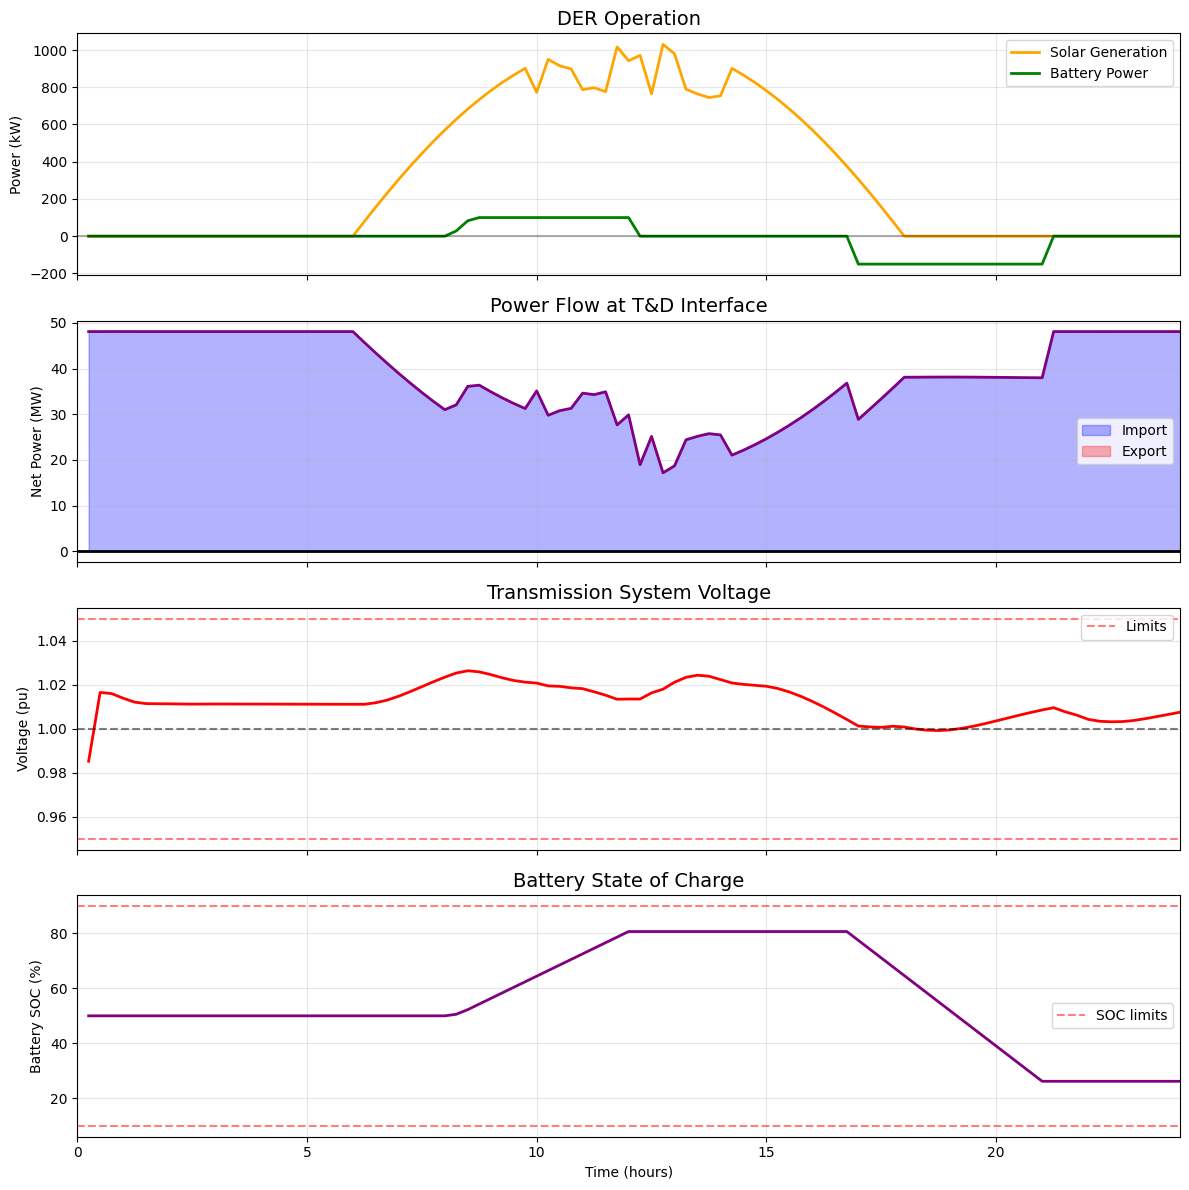


Co-simulation Results Summary:
Peak Solar Generation: 1031 kW
Max Power Export: -17190 kW
Hours with Reverse Flow: 0.0
Min Transmission Voltage: 0.985 pu
Max Transmission Voltage: 1.026 pu


In [14]:
# Visualize results
fig = cosim.visualize_results(trans_results, dist_results)
plt.show()

# Print summary
cosim.print_summary(trans_results, dist_results)

Running DER Impact Analysis with Co-simulation


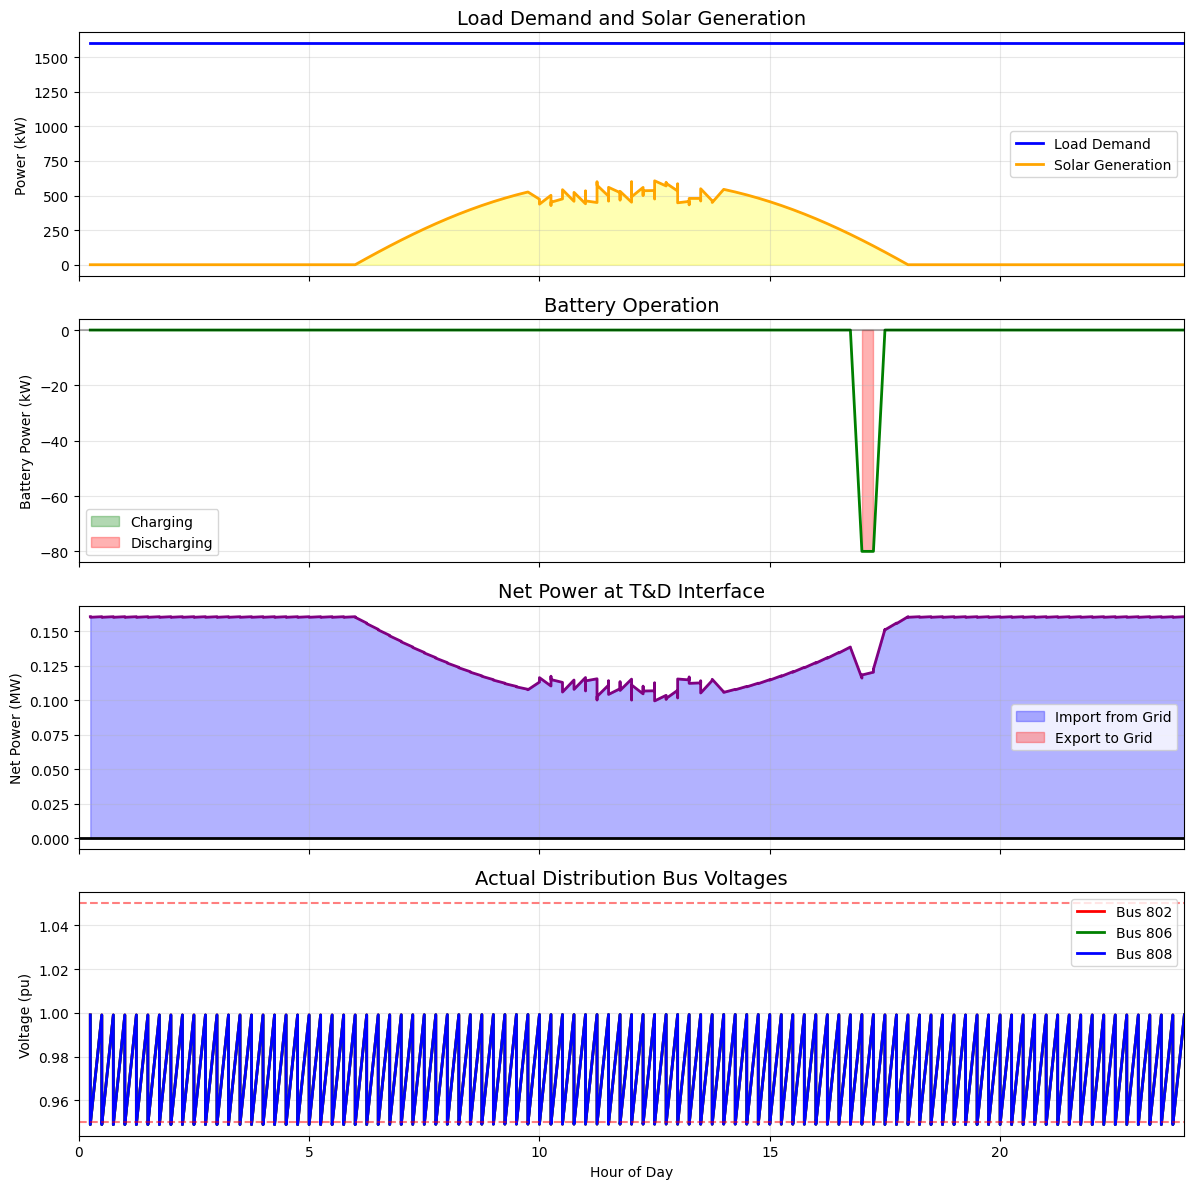


DER Impact Analysis Summary (from Co-simulation)
Peak Load: 1600 kW
Peak Solar: 607 kW
Peak Net Export: -99 kW
Hours with Reverse Flow: 0.0 hours
Daily Solar Energy: 4508 kWh
Solar Penetration: 44%

Voltage Statistics:
Min Voltage: 0.949 pu
Max Voltage: 0.999 pu
Voltage Violations: 519 instances


In [8]:
# Run actual cosimulation to analyze DER impacts
def analyze_der_impacts_with_cosimulation():
    """
    Analyze the impacts of DERs on distribution system operation using actual cosimulation.
    """
    print("Running DER Impact Analysis with Co-simulation")
    print("=" * 50)
    
    # Start HELICS broker
    broker_proc = subprocess.Popen(
        ["helics_broker", "-f", "3", "--consoleloglevel=Warning"],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    time.sleep(1)
    
    # Run federates with actual power flow calculations
    trans_results = None
    dist_results = None
    voltage_results = None
    
    def run_transmission():
        nonlocal trans_results
        fedinfo = h.helicsCreateFederateInfo()
        h.helicsFederateInfoSetCoreName(fedinfo, "TransmissionAnalysis")
        h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
        h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
        
        fed = h.helicsCreateValueFederate("TransmissionAnalysis", fedinfo)
        
        pub_voltage = h.helicsFederateRegisterGlobalPublication(
            fed, "Trans/voltage", h.helics_data_type_double, "pu"
        )
        sub_power = h.helicsFederateRegisterSubscription(
            fed, "DER_Dist/total_power", ""
        )
        
        h.helicsFederateEnterExecutingMode(fed)
        
        results = {'time': [], 'voltage': [], 'power': []}
        current_time = 0.0
        
        while current_time < 24.0:
            current_time = h.helicsFederateRequestTime(fed, current_time + 0.25)
            
            if h.helicsInputIsUpdated(sub_power):
                complex_power = h.helicsInputGetComplex(sub_power)
                p_mw = complex_power.real / 1000
                q_mvar = complex_power.imag / 1000
                
                # Actual voltage calculation with load flow
                s_mva = np.sqrt(p_mw**2 + q_mvar**2)
                pf = p_mw / s_mva if s_mva > 0 else 1.0
                
                # Voltage drop calculation
                r_pu = 0.02
                x_pu = 0.1
                v_drop = (p_mw * r_pu + q_mvar * x_pu) / 100  # 100 MVA base
                voltage = 1.0 - v_drop
                
                # Apply voltage regulation
                if voltage > 1.05:
                    voltage = 1.05
                elif voltage < 0.95:
                    voltage = 0.95
                    
                h.helicsPublicationPublishDouble(pub_voltage, voltage)
                
                results['time'].append(current_time)
                results['voltage'].append(voltage)
                results['power'].append(p_mw)
        
        h.helicsFederateFree(fed)
        trans_results = results
    
    def run_distribution_analysis():
        nonlocal dist_results, voltage_results
        fedinfo = h.helicsCreateFederateInfo()
        h.helicsFederateInfoSetCoreName(fedinfo, "DistributionAnalysis")
        h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
        h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
        
        fed = h.helicsCreateValueFederate("DistributionAnalysis", fedinfo)
        
        pub_power = h.helicsFederateRegisterGlobalPublication(
            fed, "DER_Dist/total_power", h.helics_data_type_complex, ""
        )
        pub_voltages = h.helicsFederateRegisterGlobalPublication(
            fed, "DER_Dist/bus_voltages", h.helics_data_type_string, ""
        )
        
        sub_voltage = h.helicsFederateRegisterSubscription(
            fed, "Trans/voltage", ""
        )
        
        h.helicsFederateEnterExecutingMode(fed)
        
        # Initialize OpenDSS system
        create_der_enabled_distribution_system()
        
        # Create DER models
        pv1 = SimpleSolarPV(rated_kw=200)
        pv2 = SimpleSolarPV(rated_kw=500)
        battery = SimpleBattery(power_kw=100, energy_kwh=400)
        
        results = {
            'time': [], 'net_power': [], 'solar_total': [],
            'battery_power': [], 'battery_soc': [], 'voltages': []
        }
        
        current_time = 0.0
        scale_factor = 0.1
        
        while current_time < 24.0:
            current_time = h.helicsFederateRequestTime(fed, current_time + 0.25)
            hour_of_day = current_time % 24
            
            # Solar generation
            if 6 <= hour_of_day <= 18:
                irradiance = 1000 * np.sin(np.pi * (hour_of_day - 6) / 12)
                if 10 <= hour_of_day <= 14:
                    irradiance *= 0.7 + 0.3 * np.random.random()
            else:
                irradiance = 0
                
            temperature = 20 + 10 * np.sin(np.pi * (hour_of_day - 6) / 12)
            
            pv1_power = pv1.calculate_power(irradiance, temperature)
            pv2_power = pv2.calculate_power(irradiance, temperature)
            total_solar = pv1_power + pv2_power
            
            # Get transmission voltage
            trans_voltage = h.helicsInputGetDouble(sub_voltage) if h.helicsInputIsUpdated(sub_voltage) else 1.0
            
            # Battery dispatch
            net_load = 1600 - total_solar
            if total_solar > 1000 and battery.soc < 0.8:
                battery_command = min(50, total_solar - 1000)
            elif 17 <= hour_of_day <= 21 and battery.soc > 0.2:
                battery_command = -80
            else:
                battery_command = 0
                
            battery_power, battery_soc = battery.charge_discharge(battery_command, 0.25)
            
            # Update OpenDSS using Command API
            dss.Command(f'Generator.PV1.kW={pv1_power:.2f}')
            dss.Command(f'Generator.PV2.kW={pv2_power:.2f}')
            dss.Command(f'Storage.Battery1.kW={-battery_power:.2f}')
            
            # Set source voltage from transmission
            dss.Command(f"Vsource.source.pu={trans_voltage:.4f}")
            dss.Command("Solve")
            
            # Get results
            total_power = dss.Circuit.TotalPower()
            p_net = -total_power[0] * scale_factor
            q_net = -total_power[1] * scale_factor
            
            # Get bus voltages
            bus_voltages = {}
            for bus in ['802', '806', '808']:
                dss.Circuit.SetActiveBus(bus)
                v_mag = dss.Bus.VMagAngle()[0] / (24900 / np.sqrt(3))
                bus_voltages[bus] = v_mag
            
            # Publish data
            h.helicsPublicationPublishComplex(pub_power, p_net*1000 + 1j*q_net*1000)
            h.helicsPublicationPublishString(pub_voltages, json.dumps(bus_voltages))
            
            results['time'].append(current_time)
            results['net_power'].append(p_net)
            results['solar_total'].append(total_solar)
            results['battery_power'].append(battery_power)
            results['battery_soc'].append(battery_soc)
            results['voltages'].append(bus_voltages)
            
        h.helicsFederateFree(fed)
        dist_results = results
        voltage_results = results['voltages']
    
    def run_monitor():
        """Monitor federate to collect voltage data"""
        fedinfo = h.helicsCreateFederateInfo()
        h.helicsFederateInfoSetCoreName(fedinfo, "Monitor")
        h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
        h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
        
        fed = h.helicsCreateValueFederate("Monitor", fedinfo)
        
        sub_voltages = h.helicsFederateRegisterSubscription(
            fed, "DER_Dist/bus_voltages", ""
        )
        
        h.helicsFederateEnterExecutingMode(fed)
        
        current_time = 0.0
        while current_time < 24.0:
            current_time = h.helicsFederateRequestTime(fed, current_time + 0.25)
        
        h.helicsFederateFree(fed)
    
    # Run federates
    trans_thread = Thread(target=run_transmission)
    dist_thread = Thread(target=run_distribution_analysis)
    monitor_thread = Thread(target=run_monitor)
    
    trans_thread.start()
    dist_thread.start()
    monitor_thread.start()
    
    trans_thread.join()
    dist_thread.join()
    monitor_thread.join()
    
    # Terminate broker
    broker_proc.terminate()
    broker_proc.wait()
    
    # Create comprehensive visualization with actual results
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    
    # Plot 1: Load and generation
    ax1 = axes[0]
    hours = np.array(dist_results['time'])
    load_profile = 1600 * np.ones_like(hours)  # Constant load assumption
    ax1.plot(hours, load_profile, 'b-', linewidth=2, label='Load Demand')
    ax1.plot(hours, dist_results['solar_total'], 'orange', linewidth=2, label='Solar Generation')
    ax1.fill_between(hours, 0, dist_results['solar_total'], alpha=0.3, color='yellow')
    ax1.set_ylabel('Power (kW)')
    ax1.set_title('Load Demand and Solar Generation', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Battery operation
    ax2 = axes[1]
    ax2.plot(hours, dist_results['battery_power'], 'g-', linewidth=2)
    ax2.fill_between(hours, 0, dist_results['battery_power'], 
                      where=np.array(dist_results['battery_power'])>0,
                      alpha=0.3, color='green', label='Charging')
    ax2.fill_between(hours, 0, dist_results['battery_power'], 
                      where=np.array(dist_results['battery_power'])<0,
                      alpha=0.3, color='red', label='Discharging')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax2.set_ylabel('Battery Power (kW)')
    ax2.set_title('Battery Operation', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Net power flow
    ax3 = axes[2]
    net_power_mw = np.array(dist_results['net_power']) / 1000
    ax3.plot(hours, net_power_mw, 'purple', linewidth=2)
    ax3.fill_between(hours, 0, net_power_mw, where=net_power_mw>0,
                      alpha=0.3, color='blue', label='Import from Grid')
    ax3.fill_between(hours, 0, net_power_mw, where=net_power_mw<0,
                      alpha=0.3, color='red', label='Export to Grid')
    ax3.axhline(y=0, color='k', linestyle='-', linewidth=2)
    ax3.set_ylabel('Net Power (MW)')
    ax3.set_title('Net Power at T&D Interface', fontsize=14)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Actual bus voltages from OpenDSS
    ax4 = axes[3]
    # Extract voltage data for each bus
    v_802 = [v['802'] for v in voltage_results]
    v_806 = [v['806'] for v in voltage_results]
    v_808 = [v['808'] for v in voltage_results]
    
    ax4.plot(hours, v_802, 'r-', linewidth=2, label='Bus 802')
    ax4.plot(hours, v_806, 'g-', linewidth=2, label='Bus 806')
    ax4.plot(hours, v_808, 'b-', linewidth=2, label='Bus 808')
    ax4.axhline(y=1.05, color='r', linestyle='--', alpha=0.5)
    ax4.axhline(y=0.95, color='r', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Hour of Day')
    ax4.set_ylabel('Voltage (pu)')
    ax4.set_title('Actual Distribution Bus Voltages', fontsize=14)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, 24)
    
    plt.tight_layout()
    # plt.savefig('der_impact_analysis.png', dpi=150)
    # plt.close(fig)  # Close figure to save memory
    plt.show()
    
    # Calculate key metrics from actual results
    print("\nDER Impact Analysis Summary (from Co-simulation)")
    print("=" * 50)
    print(f"Peak Load: {max(load_profile):.0f} kW")
    print(f"Peak Solar: {max(dist_results['solar_total']):.0f} kW")
    print(f"Peak Net Export: {-min(net_power_mw)*1000:.0f} kW")
    print(f"Hours with Reverse Flow: {sum(np.array(net_power_mw) < 0) * 0.25:.1f} hours")
    print(f"Daily Solar Energy: {np.trapezoid(dist_results['solar_total'], hours):.0f} kWh")
    print(f"Solar Penetration: {700 / 1600 * 100:.0f}%")
    
    # Voltage analysis
    all_voltages = []
    for v_dict in voltage_results:
        all_voltages.extend(v_dict.values())
    print(f"\nVoltage Statistics:")
    print(f"Min Voltage: {min(all_voltages):.3f} pu")
    print(f"Max Voltage: {max(all_voltages):.3f} pu")
    print(f"Voltage Violations: {sum(v > 1.05 or v < 0.95 for v in all_voltages)} instances")
    
    return dist_results, trans_results, voltage_results

# Run the analysis
dist_results, trans_results, voltage_results = analyze_der_impacts_with_cosimulation()

## Summary and Future Directions

This lesson demonstrated how distributed energy resources fundamentally change power system operation and the critical role of co-simulation in analyzing these changes. Key takeaways include:

### Technical Insights

1. **Bidirectional Power Flow**: DERs can cause distribution systems to export power to transmission, requiring new protection and control strategies.

2. **Voltage Regulation Challenges**: High DER penetration can cause voltage rise during low load periods, potentially requiring curtailment or advanced inverter controls.

3. **Coordination Opportunities**: Battery storage can mitigate solar intermittency while providing multiple grid services including peak shaving and frequency regulation.

### Co-simulation Value

The integrated T&D co-simulation with DERs enables analyses impossible with traditional tools:
- Capturing transmission system impacts of distributed generation
- Evaluating distribution hosting capacity considering transmission constraints
- Optimizing DER dispatch for system-wide benefits

### Future Applications

The framework developed here extends to many emerging grid challenges:
- Electric vehicle integration and vehicle-to-grid services
- Microgrid formation and islanding studies
- Resilience analysis with DER black-start capabilities
- Market integration for DER participation in wholesale markets

As power systems continue evolving toward distributed, renewable, and interactive grids, co-simulation becomes an essential tool for planning and operations. The skills you've developed in this module provide a foundation for addressing the complex challenges of tomorrow's power systems.